In [1]:
# import libraries

# to handle the data
import pandas as pd
import numpy as np

# to visualize the dataset
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

# to preprocess the data
from sklearn.preprocessing import MinMaxScaler, LabelEncoder    

# machine learning
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.utils import shuffle

# model
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

# evaluation
from sklearn.metrics import roc_auc_score, accuracy_score

# max columns 
pd.set_option('display.max_columns', None)

# hide warnings
import warnings
warnings.filterwarnings('ignore')

# adjust parameters
import optuna

# sampling
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

from collections import Counter
from math import *

In [2]:
# train data
df = pd.read_csv("bank-full.csv",sep = ';')
df = shuffle(df,random_state = 42)

In [3]:
def get_vectors(df_train,df_test,col_name):

    vectorizer = TfidfVectorizer(max_features=1024)
    vectors_train = vectorizer.fit_transform(df_train[col_name])
    vectors_test = vectorizer.transform(df_test[col_name])
    
    #Dimensionality Reduction Using SVD ( Singular Value Decompostion)
    svd = TruncatedSVD(8)
    x_sv_train = svd.fit_transform(vectors_train)
    x_sv_test = svd.transform(vectors_test)

    # Convert to DataFrames
    tfidf_df_train = pd.DataFrame(x_sv_train)
    tfidf_df_test = pd.DataFrame(x_sv_test)

    # Naming columns in the new DataFrames
    cols = [(col_name + "_tfidf_" + str(f)) for f in tfidf_df_train.columns.to_list()]
    tfidf_df_train.columns = cols
    tfidf_df_test.columns = cols

    # Reset the index of the DataFrames before concatenation
    df_train = df_train.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    # Concatenate transformed features with original data
    df_train = pd.concat([df_train, tfidf_df_train], axis="columns")
    df_test = pd.concat([df_test, tfidf_df_test], axis="columns")
    
    # remove the duplicates
    df_train = df_train.groupby(level=0,axis=1).last()
    df_test = df_test.groupby(level=0,axis=1).last()
    
    return df_train,df_test


def label_binary(df_train,df_test):
    # 'default','housing','loan' - binary
    # no = 0, yes =1
    label_encoder = LabelEncoder()
    object_cols = ['default','housing','loan','y']
    for col in object_cols:
        df_train[col] = label_encoder.fit_transform(df_train[col])
        df_test[col] = label_encoder.transform(df_test[col])
    return df_train,df_test

def onehot(df):
    cat_cols = ['marital','education','contact','poutcome']
    #onehotEncoding
    try:
        df=pd.get_dummies(df,columns=cat_cols)
        return df
    except:
        print('there is no cat_cols in the df')
        return df
    
def MCC(y_true, y_pred):
    cm = metrics.confusion_matrix(y_true, y_pred)
    TP = cm[0][0]
    FN = cm[0][1]
    FP = cm[1][0]
    TN = cm[1][1]
    mcc = (TP*TN-FP*FN)/sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
    return mcc

In [4]:
X_kos_folds = []
y_kos_folds = []
df_test_folds = []
feat_cols_folds = []
k = 5
for i in range(k):
    
    # 5 folds split
    n = df.shape[0]//5 # split point
    df_train = pd.concat([df[:i*n],df[(i+1)*n:]])
    df_test = df[i*n:(i+1)*n]

    # process numerical variables
    numeirc_cols = ['age','balance','duration','campaign','pdays','previous','day']
    for col in numeirc_cols:
        sc = MinMaxScaler()
        df_train[col+"_scaled"] = sc.fit_transform(df_train[[col]])
        df_test[col+"_scaled"] = sc.transform(df_test[[col]])
    
    # process categorical variables
    df_train,df_test = label_binary(df_train,df_test)
    df_train = onehot(df_train)
    df_test = onehot(df_test)
    
    # Selecting Columns FOr use 
    feat_cols=df_train.columns.drop(['y'])
    feat_cols=feat_cols.drop(numeirc_cols)
    
    # choose predictor and responser
    X=df_train[feat_cols]
    y=df_train['y']
    
    # combining sampling
    kos = SMOTETomek(random_state=0)
    X_kos, y_kos = kos.fit_resample(X, y)
    print(f'The Shape Of X is {X_kos.shape}')
    print(f'The Shape Of y is {y_kos.shape}')
    
    X_kos_folds.append(X_kos)
    y_kos_folds.append(y_kos)
    df_test_folds.append(df_test)
    feat_cols_folds.append(feat_cols)

The Shape Of X is (63062, 32)
The Shape Of y is (63062,)
The Shape Of X is (62868, 32)
The Shape Of y is (62868,)
The Shape Of X is (63064, 32)
The Shape Of y is (63064,)
The Shape Of X is (62826, 32)
The Shape Of y is (62826,)
The Shape Of X is (62946, 32)
The Shape Of y is (62946,)


In [5]:
def plot_matrix(cm, labels_name, title=None, thresh=0.8, axis_labels=None):
# 利用sklearn中的函数生成混淆矩阵并归一化
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # 归一化

# 画图，如果希望改变颜色风格，可以改变此部分的cmap=pl.get_cmap('Blues')处
    plt.imshow(cm, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.colorbar()  # 绘制图例

# 图像标题
    if title is not None:
        plt.title(title)
# 绘制坐标
    num_local = np.array(range(len(labels_name)))
    if axis_labels is None:
        axis_labels = labels_name
    plt.xticks(num_local, axis_labels, rotation=45)  # 将标签印在x轴坐标上， 并倾斜45度
    plt.yticks(num_local, axis_labels)  # 将标签印在y轴坐标上
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# 将百分比打印在相应的格子内，大于thresh的用白字，小于的用黑字
    for i in range(np.shape(cm)[0]):
        for j in range(np.shape(cm)[1]):
            if int(cm[i][j] * 100 + 0.5) > 0:
                plt.text(j, i, format(int(cm[i][j] * 100 + 0.5), 'd') + '%',
                        ha="center", va="center",
                        color="white" if cm[i][j] > thresh else "black")  # 如果要更改颜色风格，需要同时更改此行
                

In [24]:
# LightGBM Parameters adjusting
def objective(trial):
    Params = {
        'n_estimators': 227,#trial.suggest_int('n_estimators',100, 400),
        'num_leaves': 127,#trial.suggest_int('num_leaves',100,300),
        'learning_rate': 0.015,#trial.suggest_categorical('learning_rate',[0.01,0.005,0.015,0.02,0.025]),
        'max_depth': 43,#trial.suggest_int('max_depth',20,80),
        'min_child_weight': 1e-05,#trial.suggest_categorical('min_child_weight',[0.001,0.0001,0.00001,0.000001,0.0000001,0]),
        'min_child_samples': 12,#trial.suggest_int('min_child_samples',5, 32),
        'subsample': 0.9, #trial.suggest_categorical('subsample',[0.8,0.9,1]),
        'colsample_bytree': 0.8, #trial.suggest_categorical('colsample_bytree',[0.8,0.9,1]),
        'verbose':-1
    }
    
    lgb_mcc = []
    for i in range(k):
        X_kos = X_kos_folds[i]
        y_kos = y_kos_folds[i]
        df_test = df_test_folds[i]
        feat_cols = feat_cols_folds[i]

        # train the model
        lgb_model = lgb.LGBMClassifier(**Params)
        lgb_model.fit(X_kos,y_kos)
        test_predictions = lgb_model.predict_proba(df_test[feat_cols])[:, 1]
        test_labels = [i >= 0.5 for i in test_predictions]
        mcc = MCC(df_test['y'], test_labels)
        lgb_mcc.append(mcc)

    return sum(lgb_mcc)/5

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50,show_progress_bar=True)

[I 2024-09-28 00:18:23,854] A new study created in memory with name: no-name-8827e9f9-c480-40e4-9b8c-0cfb9fb2f3fd
Best trial: 0. Best value: 0.521434: 100%|██████████| 1/1 [00:02<00:00,  2.07s/it]

[I 2024-09-28 00:18:25,922] Trial 0 finished with value: 0.5214336802155245 and parameters: {}. Best is trial 0 with value: 0.5214336802155245.


In [18]:
best_params = study.best_params
print(f"Best Params: {best_params}")
optuna.visualization.plot_param_importances(study).show()
optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_slice(study).show()

Best Params: {'n_estimators': 226, 'num_leaves': 127, 'learning_rate': 0.015, 'max_depth': 43, 'min_child_weight': 1e-05, 'min_child_samples': 12}


In [19]:
# CatBoostClassifier
def objective(trial):
    Params = {
        'eval_metric':'AUC',
        'iterations': 1000,
        'depth': trial.suggest_int('depth',1,16),
        'learning_rate': trial.suggest_categorical('learning_rate',[0.005 * i for i in range(1,21)]),
        'subsample': trial.suggest_categorical('subsample',[0.8,0.9,1]),
        'rsm': trial.suggest_categorical('rsm',[0.01*i for i in range(1,21)])s,
        'verbose': False
             }
    
    cat_mcc = []
    for i in range(k):
        X_kos = X_kos_folds[i]
        y_kos = y_kos_folds[i]
        df_test = df_test_folds[i]
        feat_cols = feat_cols_folds[i]
        
        # Cat_features
        cat_features = np.where(X_kos.dtypes != np.float64)[0]

        # Train the model on the entire dataset
        cat_model = CatBoostClassifier(**cat_params)
        train_pool = Pool(X_kos, y_kos, cat_features=cat_features)
        cat_model.fit(train_pool)

        # Make predictions on the test set
        test_pool = Pool(df_test[feat_cols], cat_features=cat_features)
        test_predictions = cat_model.predict_proba(test_pool)[:, 1]
        test_labels = [i >= 0.5 for i in test_predictions]
        mcc = MCC(df_test['y'], test_labels)
        cat_mcc.append(mcc)

        # train the model
        cat_model = CatBoostClassifier(**Params)
        cat_model.fit(X_kos,y_kos)
        test_predictions = cat_model.predict_proba(df_test[feat_cols])[:, 1]
        test_labels = [i >= 0.5 for i in test_predictions]
        mcc = MCC(df_test['y'], test_labels)
        cat_mcc.append(mcc)

    return sum(cat_mcc)/5

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50,show_progress_bar=True)

0:	total: 92.8ms	remaining: 1m 32s
1:	total: 104ms	remaining: 51.7s
2:	total: 116ms	remaining: 38.4s
3:	total: 129ms	remaining: 32.1s
4:	total: 139ms	remaining: 27.7s
5:	total: 1.77s	remaining: 4m 53s
6:	total: 3.31s	remaining: 7m 50s
7:	total: 4.91s	remaining: 10m 9s
8:	total: 4.93s	remaining: 9m 2s
9:	total: 5.02s	remaining: 8m 17s
10:	total: 5.16s	remaining: 7m 44s
11:	total: 6.71s	remaining: 9m 12s
12:	total: 6.74s	remaining: 8m 31s
13:	total: 8.3s	remaining: 9m 44s
14:	total: 9.86s	remaining: 10m 47s
15:	total: 11.5s	remaining: 11m 48s
16:	total: 11.6s	remaining: 11m 12s
17:	total: 13.3s	remaining: 12m 4s
18:	total: 14.2s	remaining: 12m 13s
19:	total: 14.3s	remaining: 11m 40s
20:	total: 14.3s	remaining: 11m 6s
21:	total: 14.3s	remaining: 10m 36s
22:	total: 16s	remaining: 11m 18s
23:	total: 17.6s	remaining: 11m 53s
24:	total: 17.6s	remaining: 11m 26s
25:	total: 19.1s	remaining: 11m 56s
26:	total: 19.2s	remaining: 11m 30s
27:	total: 19.3s	remaining: 11m 8s
28:	total: 19.3s	remaining

224:	total: 3m 6s	remaining: 10m 43s
225:	total: 3m 6s	remaining: 10m 39s
226:	total: 3m 8s	remaining: 10m 41s
227:	total: 3m 8s	remaining: 10m 38s
228:	total: 3m 8s	remaining: 10m 34s
229:	total: 3m 10s	remaining: 10m 36s
230:	total: 3m 10s	remaining: 10m 33s
231:	total: 3m 11s	remaining: 10m 35s
232:	total: 3m 11s	remaining: 10m 31s
233:	total: 3m 12s	remaining: 10m 28s
234:	total: 3m 12s	remaining: 10m 25s
235:	total: 3m 13s	remaining: 10m 27s
236:	total: 3m 13s	remaining: 10m 23s
237:	total: 3m 15s	remaining: 10m 25s
238:	total: 3m 17s	remaining: 10m 28s
239:	total: 3m 18s	remaining: 10m 30s
240:	total: 3m 20s	remaining: 10m 32s
241:	total: 3m 22s	remaining: 10m 34s
242:	total: 3m 24s	remaining: 10m 35s
243:	total: 3m 24s	remaining: 10m 32s
244:	total: 3m 24s	remaining: 10m 29s
245:	total: 3m 24s	remaining: 10m 25s
246:	total: 3m 24s	remaining: 10m 22s
247:	total: 3m 24s	remaining: 10m 20s
248:	total: 3m 26s	remaining: 10m 21s
249:	total: 3m 27s	remaining: 10m 23s
250:	total: 3m 29

446:	total: 6m 39s	remaining: 8m 13s
447:	total: 6m 39s	remaining: 8m 11s
448:	total: 6m 39s	remaining: 8m 9s
449:	total: 6m 41s	remaining: 8m 10s
450:	total: 6m 42s	remaining: 8m 10s
451:	total: 6m 42s	remaining: 8m 8s
452:	total: 6m 42s	remaining: 8m 6s
453:	total: 6m 42s	remaining: 8m 4s
454:	total: 6m 44s	remaining: 8m 4s
455:	total: 6m 46s	remaining: 8m 5s
456:	total: 6m 48s	remaining: 8m 5s
457:	total: 6m 48s	remaining: 8m 3s
458:	total: 6m 48s	remaining: 8m 1s
459:	total: 6m 50s	remaining: 8m 1s
460:	total: 6m 50s	remaining: 7m 59s
461:	total: 6m 50s	remaining: 7m 58s
462:	total: 6m 50s	remaining: 7m 56s
463:	total: 6m 50s	remaining: 7m 54s
464:	total: 6m 52s	remaining: 7m 54s
465:	total: 6m 54s	remaining: 7m 54s
466:	total: 6m 56s	remaining: 7m 55s
467:	total: 6m 56s	remaining: 7m 53s
468:	total: 6m 56s	remaining: 7m 51s
469:	total: 6m 56s	remaining: 7m 49s
470:	total: 6m 58s	remaining: 7m 50s
471:	total: 7m	remaining: 7m 50s
472:	total: 7m 2s	remaining: 7m 50s
473:	total: 7m 2

670:	total: 10m 12s	remaining: 5m
671:	total: 10m 12s	remaining: 4m 58s
672:	total: 10m 13s	remaining: 4m 57s
673:	total: 10m 13s	remaining: 4m 56s
674:	total: 10m 14s	remaining: 4m 55s
675:	total: 10m 14s	remaining: 4m 54s
676:	total: 10m 14s	remaining: 4m 53s
677:	total: 10m 15s	remaining: 4m 52s
678:	total: 10m 16s	remaining: 4m 51s
679:	total: 10m 18s	remaining: 4m 51s
680:	total: 10m 18s	remaining: 4m 49s
681:	total: 10m 18s	remaining: 4m 48s
682:	total: 10m 18s	remaining: 4m 47s
683:	total: 10m 20s	remaining: 4m 46s
684:	total: 10m 20s	remaining: 4m 45s
685:	total: 10m 22s	remaining: 4m 44s
686:	total: 10m 23s	remaining: 4m 44s
687:	total: 10m 25s	remaining: 4m 43s
688:	total: 10m 25s	remaining: 4m 42s
689:	total: 10m 27s	remaining: 4m 41s
690:	total: 10m 27s	remaining: 4m 40s
691:	total: 10m 29s	remaining: 4m 40s
692:	total: 10m 29s	remaining: 4m 38s
693:	total: 10m 31s	remaining: 4m 38s
694:	total: 10m 31s	remaining: 4m 37s
695:	total: 10m 32s	remaining: 4m 36s
696:	total: 10m 

889:	total: 13m 11s	remaining: 1m 37s
890:	total: 13m 11s	remaining: 1m 36s
891:	total: 13m 11s	remaining: 1m 35s
892:	total: 13m 13s	remaining: 1m 35s
893:	total: 13m 15s	remaining: 1m 34s
894:	total: 13m 17s	remaining: 1m 33s
895:	total: 13m 17s	remaining: 1m 32s
896:	total: 13m 18s	remaining: 1m 31s
897:	total: 13m 19s	remaining: 1m 30s
898:	total: 13m 21s	remaining: 1m 30s
899:	total: 13m 21s	remaining: 1m 29s
900:	total: 13m 23s	remaining: 1m 28s
901:	total: 13m 24s	remaining: 1m 27s
902:	total: 13m 24s	remaining: 1m 26s
903:	total: 13m 25s	remaining: 1m 25s
904:	total: 13m 27s	remaining: 1m 24s
905:	total: 13m 28s	remaining: 1m 23s
906:	total: 13m 28s	remaining: 1m 22s
907:	total: 13m 28s	remaining: 1m 21s
908:	total: 13m 30s	remaining: 1m 21s
909:	total: 13m 30s	remaining: 1m 20s
910:	total: 13m 32s	remaining: 1m 19s
911:	total: 13m 34s	remaining: 1m 18s
912:	total: 13m 35s	remaining: 1m 17s
913:	total: 13m 35s	remaining: 1m 16s
914:	total: 13m 37s	remaining: 1m 15s
915:	total: 

115:	total: 1m 33s	remaining: 11m 48s
116:	total: 1m 34s	remaining: 11m 54s
117:	total: 1m 36s	remaining: 11m 59s
118:	total: 1m 37s	remaining: 12m 5s
119:	total: 1m 38s	remaining: 12m 2s
120:	total: 1m 40s	remaining: 12m 7s
121:	total: 1m 41s	remaining: 12m 13s
122:	total: 1m 41s	remaining: 12m 6s
123:	total: 1m 41s	remaining: 12m
124:	total: 1m 42s	remaining: 11m 54s
125:	total: 1m 42s	remaining: 11m 48s
126:	total: 1m 44s	remaining: 11m 56s
127:	total: 1m 45s	remaining: 12m 2s
128:	total: 1m 45s	remaining: 11m 55s
129:	total: 1m 46s	remaining: 11m 50s
130:	total: 1m 48s	remaining: 11m 57s
131:	total: 1m 49s	remaining: 12m 2s
132:	total: 1m 49s	remaining: 11m 56s
133:	total: 1m 51s	remaining: 12m 1s
134:	total: 1m 51s	remaining: 11m 55s
135:	total: 1m 53s	remaining: 11m 59s
136:	total: 1m 54s	remaining: 12m 2s
137:	total: 1m 54s	remaining: 11m 57s
138:	total: 1m 54s	remaining: 11m 51s
139:	total: 1m 56s	remaining: 11m 54s
140:	total: 1m 56s	remaining: 11m 48s
141:	total: 1m 57s	remai

335:	total: 4m 51s	remaining: 9m 36s
336:	total: 4m 53s	remaining: 9m 37s
337:	total: 4m 55s	remaining: 9m 37s
338:	total: 4m 55s	remaining: 9m 35s
339:	total: 4m 56s	remaining: 9m 35s
340:	total: 4m 58s	remaining: 9m 36s
341:	total: 5m	remaining: 9m 37s
342:	total: 5m 1s	remaining: 9m 38s
343:	total: 5m 1s	remaining: 9m 35s
344:	total: 5m 3s	remaining: 9m 36s
345:	total: 5m 5s	remaining: 9m 36s
346:	total: 5m 6s	remaining: 9m 37s
347:	total: 5m 6s	remaining: 9m 34s
348:	total: 5m 8s	remaining: 9m 35s
349:	total: 5m 10s	remaining: 9m 36s
350:	total: 5m 10s	remaining: 9m 34s
351:	total: 5m 11s	remaining: 9m 32s
352:	total: 5m 11s	remaining: 9m 30s
353:	total: 5m 11s	remaining: 9m 28s
354:	total: 5m 13s	remaining: 9m 28s
355:	total: 5m 14s	remaining: 9m 29s
356:	total: 5m 16s	remaining: 9m 30s
357:	total: 5m 18s	remaining: 9m 30s
358:	total: 5m 20s	remaining: 9m 31s
359:	total: 5m 20s	remaining: 9m 28s
360:	total: 5m 20s	remaining: 9m 26s
361:	total: 5m 21s	remaining: 9m 27s
362:	total: 

559:	total: 8m 25s	remaining: 6m 37s
560:	total: 8m 25s	remaining: 6m 35s
561:	total: 8m 27s	remaining: 6m 35s
562:	total: 8m 27s	remaining: 6m 33s
563:	total: 8m 27s	remaining: 6m 32s
564:	total: 8m 27s	remaining: 6m 30s
565:	total: 8m 27s	remaining: 6m 29s
566:	total: 8m 29s	remaining: 6m 28s
567:	total: 8m 30s	remaining: 6m 28s
568:	total: 8m 32s	remaining: 6m 28s
569:	total: 8m 34s	remaining: 6m 28s
570:	total: 8m 34s	remaining: 6m 26s
571:	total: 8m 36s	remaining: 6m 26s
572:	total: 8m 36s	remaining: 6m 24s
573:	total: 8m 38s	remaining: 6m 24s
574:	total: 8m 39s	remaining: 6m 24s
575:	total: 8m 41s	remaining: 6m 23s
576:	total: 8m 43s	remaining: 6m 23s
577:	total: 8m 43s	remaining: 6m 22s
578:	total: 8m 45s	remaining: 6m 21s
579:	total: 8m 46s	remaining: 6m 21s
580:	total: 8m 48s	remaining: 6m 21s
581:	total: 8m 50s	remaining: 6m 20s
582:	total: 8m 51s	remaining: 6m 20s
583:	total: 8m 51s	remaining: 6m 18s
584:	total: 8m 51s	remaining: 6m 17s
585:	total: 8m 53s	remaining: 6m 16s
5

784:	total: 11m 31s	remaining: 3m 9s
785:	total: 11m 31s	remaining: 3m 8s
786:	total: 11m 32s	remaining: 3m 7s
787:	total: 11m 34s	remaining: 3m 6s
788:	total: 11m 34s	remaining: 3m 5s
789:	total: 11m 36s	remaining: 3m 5s
790:	total: 11m 38s	remaining: 3m 4s
791:	total: 11m 38s	remaining: 3m 3s
792:	total: 11m 40s	remaining: 3m 2s
793:	total: 11m 40s	remaining: 3m 1s
794:	total: 11m 41s	remaining: 3m
795:	total: 11m 43s	remaining: 3m
796:	total: 11m 45s	remaining: 2m 59s
797:	total: 11m 46s	remaining: 2m 58s
798:	total: 11m 48s	remaining: 2m 58s
799:	total: 11m 48s	remaining: 2m 57s
800:	total: 11m 50s	remaining: 2m 56s
801:	total: 11m 50s	remaining: 2m 55s
802:	total: 11m 50s	remaining: 2m 54s
803:	total: 11m 50s	remaining: 2m 53s
804:	total: 11m 50s	remaining: 2m 52s
805:	total: 11m 52s	remaining: 2m 51s
806:	total: 11m 52s	remaining: 2m 50s
807:	total: 11m 52s	remaining: 2m 49s
808:	total: 11m 52s	remaining: 2m 48s
809:	total: 11m 54s	remaining: 2m 47s
810:	total: 11m 54s	remaining:

5:	total: 1.99s	remaining: 5m 28s
6:	total: 3.5s	remaining: 8m 17s
7:	total: 3.54s	remaining: 7m 19s
8:	total: 3.63s	remaining: 6m 40s
9:	total: 5.09s	remaining: 8m 23s
10:	total: 6.61s	remaining: 9m 53s
11:	total: 6.63s	remaining: 9m 5s
12:	total: 8.19s	remaining: 10m 22s
13:	total: 9.71s	remaining: 11m 23s
14:	total: 11.3s	remaining: 12m 19s
15:	total: 11.4s	remaining: 11m 40s
16:	total: 13s	remaining: 12m 32s
17:	total: 13.9s	remaining: 12m 38s
18:	total: 14s	remaining: 12m 1s
19:	total: 14s	remaining: 11m 26s
20:	total: 14s	remaining: 10m 53s
21:	total: 15.5s	remaining: 11m 30s
22:	total: 17s	remaining: 12m 1s
23:	total: 17s	remaining: 11m 31s
24:	total: 18.5s	remaining: 12m 1s
25:	total: 18.5s	remaining: 11m 34s
26:	total: 18.6s	remaining: 11m 11s
27:	total: 18.6s	remaining: 10m 47s
28:	total: 18.7s	remaining: 10m 24s
29:	total: 20.1s	remaining: 10m 49s
30:	total: 21.5s	remaining: 11m 10s
31:	total: 23s	remaining: 11m 37s
32:	total: 23.1s	remaining: 11m 16s
33:	total: 24.6s	remain

230:	total: 2m 51s	remaining: 9m 31s
231:	total: 2m 53s	remaining: 9m 34s
232:	total: 2m 53s	remaining: 9m 31s
233:	total: 2m 55s	remaining: 9m 33s
234:	total: 2m 55s	remaining: 9m 30s
235:	total: 2m 55s	remaining: 9m 27s
236:	total: 2m 56s	remaining: 9m 29s
237:	total: 2m 56s	remaining: 9m 26s
238:	total: 2m 57s	remaining: 9m 23s
239:	total: 2m 57s	remaining: 9m 22s
240:	total: 2m 57s	remaining: 9m 19s
241:	total: 2m 57s	remaining: 9m 17s
242:	total: 2m 59s	remaining: 9m 18s
243:	total: 2m 59s	remaining: 9m 15s
244:	total: 3m	remaining: 9m 17s
245:	total: 3m 1s	remaining: 9m 14s
246:	total: 3m 1s	remaining: 9m 11s
247:	total: 3m 2s	remaining: 9m 13s
248:	total: 3m 4s	remaining: 9m 15s
249:	total: 3m 5s	remaining: 9m 17s
250:	total: 3m 5s	remaining: 9m 14s
251:	total: 3m 7s	remaining: 9m 16s
252:	total: 3m 7s	remaining: 9m 13s
253:	total: 3m 8s	remaining: 9m 12s
254:	total: 3m 9s	remaining: 9m 14s
255:	total: 3m 11s	remaining: 9m 17s
256:	total: 3m 13s	remaining: 9m 19s
257:	total: 3m 

455:	total: 6m 13s	remaining: 7m 25s
456:	total: 6m 13s	remaining: 7m 24s
457:	total: 6m 15s	remaining: 7m 24s
458:	total: 6m 17s	remaining: 7m 24s
459:	total: 6m 17s	remaining: 7m 22s
460:	total: 6m 17s	remaining: 7m 20s
461:	total: 6m 17s	remaining: 7m 19s
462:	total: 6m 18s	remaining: 7m 19s
463:	total: 6m 20s	remaining: 7m 19s
464:	total: 6m 22s	remaining: 7m 19s
465:	total: 6m 22s	remaining: 7m 18s
466:	total: 6m 22s	remaining: 7m 16s
467:	total: 6m 23s	remaining: 7m 16s
468:	total: 6m 24s	remaining: 7m 15s
469:	total: 6m 24s	remaining: 7m 13s
470:	total: 6m 24s	remaining: 7m 11s
471:	total: 6m 24s	remaining: 7m 10s
472:	total: 6m 26s	remaining: 7m 10s
473:	total: 6m 27s	remaining: 7m 10s
474:	total: 6m 29s	remaining: 7m 10s
475:	total: 6m 29s	remaining: 7m 8s
476:	total: 6m 31s	remaining: 7m 8s
477:	total: 6m 32s	remaining: 7m 8s
478:	total: 6m 34s	remaining: 7m 8s
479:	total: 6m 35s	remaining: 7m 8s
480:	total: 6m 37s	remaining: 7m 9s
481:	total: 6m 39s	remaining: 7m 9s
482:	tot

681:	total: 9m 32s	remaining: 4m 26s
682:	total: 9m 34s	remaining: 4m 26s
683:	total: 9m 34s	remaining: 4m 25s
684:	total: 9m 35s	remaining: 4m 24s
685:	total: 9m 36s	remaining: 4m 23s
686:	total: 9m 36s	remaining: 4m 22s
687:	total: 9m 36s	remaining: 4m 21s
688:	total: 9m 37s	remaining: 4m 20s
689:	total: 9m 37s	remaining: 4m 19s
690:	total: 9m 37s	remaining: 4m 18s
691:	total: 9m 39s	remaining: 4m 17s
692:	total: 9m 39s	remaining: 4m 16s
693:	total: 9m 39s	remaining: 4m 15s
694:	total: 9m 40s	remaining: 4m 14s
695:	total: 9m 40s	remaining: 4m 13s
696:	total: 9m 40s	remaining: 4m 12s
697:	total: 9m 42s	remaining: 4m 11s
698:	total: 9m 42s	remaining: 4m 10s
699:	total: 9m 43s	remaining: 4m 10s
700:	total: 9m 45s	remaining: 4m 9s
701:	total: 9m 47s	remaining: 4m 9s
702:	total: 9m 47s	remaining: 4m 8s
703:	total: 9m 48s	remaining: 4m 7s
704:	total: 9m 50s	remaining: 4m 7s
705:	total: 9m 52s	remaining: 4m 6s
706:	total: 9m 52s	remaining: 4m 5s
707:	total: 9m 53s	remaining: 4m 4s
708:	tota

900:	total: 12m 35s	remaining: 1m 23s
901:	total: 12m 37s	remaining: 1m 22s
902:	total: 12m 39s	remaining: 1m 21s
903:	total: 12m 40s	remaining: 1m 20s
904:	total: 12m 40s	remaining: 1m 19s
905:	total: 12m 42s	remaining: 1m 19s
906:	total: 12m 44s	remaining: 1m 18s
907:	total: 12m 45s	remaining: 1m 17s
908:	total: 12m 47s	remaining: 1m 16s
909:	total: 12m 47s	remaining: 1m 15s
910:	total: 12m 47s	remaining: 1m 15s
911:	total: 12m 48s	remaining: 1m 14s
912:	total: 12m 50s	remaining: 1m 13s
913:	total: 12m 52s	remaining: 1m 12s
914:	total: 12m 52s	remaining: 1m 11s
915:	total: 12m 52s	remaining: 1m 10s
916:	total: 12m 54s	remaining: 1m 10s
917:	total: 12m 54s	remaining: 1m 9s
918:	total: 12m 56s	remaining: 1m 8s
919:	total: 12m 57s	remaining: 1m 7s
920:	total: 12m 59s	remaining: 1m 6s
921:	total: 12m 59s	remaining: 1m 5s
922:	total: 13m 1s	remaining: 1m 5s
923:	total: 13m 1s	remaining: 1m 4s
924:	total: 13m 1s	remaining: 1m 3s
925:	total: 13m 1s	remaining: 1m 2s
926:	total: 13m 3s	remain

128:	total: 1m 26s	remaining: 9m 42s
129:	total: 1m 27s	remaining: 9m 47s
130:	total: 1m 27s	remaining: 9m 42s
131:	total: 1m 27s	remaining: 9m 38s
132:	total: 1m 29s	remaining: 9m 43s
133:	total: 1m 29s	remaining: 9m 38s
134:	total: 1m 31s	remaining: 9m 43s
135:	total: 1m 31s	remaining: 9m 39s
136:	total: 1m 32s	remaining: 9m 44s
137:	total: 1m 34s	remaining: 9m 49s
138:	total: 1m 34s	remaining: 9m 44s
139:	total: 1m 34s	remaining: 9m 39s
140:	total: 1m 36s	remaining: 9m 45s
141:	total: 1m 36s	remaining: 9m 40s
142:	total: 1m 37s	remaining: 9m 45s
143:	total: 1m 39s	remaining: 9m 49s
144:	total: 1m 39s	remaining: 9m 48s
145:	total: 1m 39s	remaining: 9m 44s
146:	total: 1m 41s	remaining: 9m 49s
147:	total: 1m 41s	remaining: 9m 44s
148:	total: 1m 41s	remaining: 9m 40s
149:	total: 1m 43s	remaining: 9m 44s
150:	total: 1m 43s	remaining: 9m 40s
151:	total: 1m 44s	remaining: 9m 43s
152:	total: 1m 44s	remaining: 9m 39s
153:	total: 1m 46s	remaining: 9m 43s
154:	total: 1m 46s	remaining: 9m 39s
1

355:	total: 4m 42s	remaining: 8m 30s
356:	total: 4m 42s	remaining: 8m 28s
357:	total: 4m 43s	remaining: 8m 28s
358:	total: 4m 45s	remaining: 8m 29s
359:	total: 4m 46s	remaining: 8m 29s
360:	total: 4m 46s	remaining: 8m 27s
361:	total: 4m 46s	remaining: 8m 25s
362:	total: 4m 46s	remaining: 8m 23s
363:	total: 4m 48s	remaining: 8m 24s
364:	total: 4m 50s	remaining: 8m 24s
365:	total: 4m 50s	remaining: 8m 22s
366:	total: 4m 50s	remaining: 8m 20s
367:	total: 4m 51s	remaining: 8m 20s
368:	total: 4m 51s	remaining: 8m 19s
369:	total: 4m 51s	remaining: 8m 17s
370:	total: 4m 51s	remaining: 8m 14s
371:	total: 4m 53s	remaining: 8m 15s
372:	total: 4m 55s	remaining: 8m 16s
373:	total: 4m 56s	remaining: 8m 16s
374:	total: 4m 56s	remaining: 8m 14s
375:	total: 4m 58s	remaining: 8m 15s
376:	total: 5m	remaining: 8m 16s
377:	total: 5m 1s	remaining: 8m 16s
378:	total: 5m 3s	remaining: 8m 17s
379:	total: 5m 5s	remaining: 8m 17s
380:	total: 5m 5s	remaining: 8m 15s
381:	total: 5m 5s	remaining: 8m 13s
382:	total

580:	total: 7m 53s	remaining: 5m 41s
581:	total: 7m 55s	remaining: 5m 41s
582:	total: 7m 56s	remaining: 5m 41s
583:	total: 7m 58s	remaining: 5m 40s
584:	total: 8m	remaining: 5m 40s
585:	total: 8m 2s	remaining: 5m 40s
586:	total: 8m 2s	remaining: 5m 39s
587:	total: 8m 3s	remaining: 5m 38s
588:	total: 8m 3s	remaining: 5m 37s
589:	total: 8m 5s	remaining: 5m 37s
590:	total: 8m 7s	remaining: 5m 37s
591:	total: 8m 7s	remaining: 5m 35s
592:	total: 8m 9s	remaining: 5m 35s
593:	total: 8m 9s	remaining: 5m 34s
594:	total: 8m 10s	remaining: 5m 34s
595:	total: 8m 12s	remaining: 5m 33s
596:	total: 8m 14s	remaining: 5m 33s
597:	total: 8m 14s	remaining: 5m 32s
598:	total: 8m 15s	remaining: 5m 31s
599:	total: 8m 17s	remaining: 5m 31s
600:	total: 8m 18s	remaining: 5m 30s
601:	total: 8m 18s	remaining: 5m 29s
602:	total: 8m 18s	remaining: 5m 28s
603:	total: 8m 20s	remaining: 5m 27s
604:	total: 8m 21s	remaining: 5m 27s
605:	total: 8m 23s	remaining: 5m 27s
606:	total: 8m 23s	remaining: 5m 26s
607:	total: 8m

804:	total: 11m 1s	remaining: 2m 40s
805:	total: 11m 1s	remaining: 2m 39s
806:	total: 11m 1s	remaining: 2m 38s
807:	total: 11m 1s	remaining: 2m 37s
808:	total: 11m 3s	remaining: 2m 36s
809:	total: 11m 3s	remaining: 2m 35s
810:	total: 11m 5s	remaining: 2m 35s
811:	total: 11m 7s	remaining: 2m 34s
812:	total: 11m 7s	remaining: 2m 33s
813:	total: 11m 7s	remaining: 2m 32s
814:	total: 11m 9s	remaining: 2m 32s
815:	total: 11m 11s	remaining: 2m 31s
816:	total: 11m 11s	remaining: 2m 30s
817:	total: 11m 11s	remaining: 2m 29s
818:	total: 11m 11s	remaining: 2m 28s
819:	total: 11m 13s	remaining: 2m 27s
820:	total: 11m 13s	remaining: 2m 26s
821:	total: 11m 15s	remaining: 2m 26s
822:	total: 11m 17s	remaining: 2m 25s
823:	total: 11m 17s	remaining: 2m 24s
824:	total: 11m 18s	remaining: 2m 23s
825:	total: 11m 20s	remaining: 2m 23s
826:	total: 11m 22s	remaining: 2m 22s
827:	total: 11m 22s	remaining: 2m 21s
828:	total: 11m 23s	remaining: 2m 21s
829:	total: 11m 25s	remaining: 2m 20s
830:	total: 11m 25s	rem

31:	total: 20.6s	remaining: 10m 23s
32:	total: 22.1s	remaining: 10m 46s
33:	total: 22.1s	remaining: 10m 28s
34:	total: 23.5s	remaining: 10m 49s
35:	total: 23.6s	remaining: 10m 31s
36:	total: 25s	remaining: 10m 51s
37:	total: 25s	remaining: 10m 34s
38:	total: 25.2s	remaining: 10m 21s
39:	total: 25.7s	remaining: 10m 16s
40:	total: 27.3s	remaining: 10m 37s
41:	total: 27.3s	remaining: 10m 22s
42:	total: 28.7s	remaining: 10m 39s
43:	total: 30.3s	remaining: 10m 57s
44:	total: 30.3s	remaining: 10m 42s
45:	total: 30.3s	remaining: 10m 29s
46:	total: 30.4s	remaining: 10m 15s
47:	total: 31.9s	remaining: 10m 31s
48:	total: 33.3s	remaining: 10m 46s
49:	total: 33.3s	remaining: 10m 32s
50:	total: 33.3s	remaining: 10m 20s
51:	total: 34.8s	remaining: 10m 34s
52:	total: 36.3s	remaining: 10m 48s
53:	total: 37.8s	remaining: 11m 2s
54:	total: 39.3s	remaining: 11m 14s
55:	total: 40.9s	remaining: 11m 28s
56:	total: 41.2s	remaining: 11m 21s
57:	total: 41.4s	remaining: 11m 13s
58:	total: 43s	remaining: 11m 26s

254:	total: 3m 33s	remaining: 10m 24s
255:	total: 3m 33s	remaining: 10m 21s
256:	total: 3m 35s	remaining: 10m 22s
257:	total: 3m 35s	remaining: 10m 19s
258:	total: 3m 35s	remaining: 10m 16s
259:	total: 3m 37s	remaining: 10m 17s
260:	total: 3m 37s	remaining: 10m 14s
261:	total: 3m 37s	remaining: 10m 11s
262:	total: 3m 37s	remaining: 10m 8s
263:	total: 3m 37s	remaining: 10m 7s
264:	total: 3m 39s	remaining: 10m 8s
265:	total: 3m 41s	remaining: 10m 9s
266:	total: 3m 42s	remaining: 10m 11s
267:	total: 3m 42s	remaining: 10m 8s
268:	total: 3m 42s	remaining: 10m 5s
269:	total: 3m 42s	remaining: 10m 2s
270:	total: 3m 44s	remaining: 10m 3s
271:	total: 3m 44s	remaining: 10m 1s
272:	total: 3m 46s	remaining: 10m 2s
273:	total: 3m 46s	remaining: 9m 59s
274:	total: 3m 46s	remaining: 9m 56s
275:	total: 3m 47s	remaining: 9m 57s
276:	total: 3m 49s	remaining: 9m 58s
277:	total: 3m 51s	remaining: 10m
278:	total: 3m 52s	remaining: 10m 1s
279:	total: 3m 54s	remaining: 10m 1s
280:	total: 3m 55s	remaining: 10

479:	total: 6m 52s	remaining: 7m 27s
480:	total: 6m 54s	remaining: 7m 27s
481:	total: 6m 56s	remaining: 7m 27s
482:	total: 6m 56s	remaining: 7m 25s
483:	total: 6m 57s	remaining: 7m 25s
484:	total: 6m 57s	remaining: 7m 23s
485:	total: 6m 59s	remaining: 7m 24s
486:	total: 7m 1s	remaining: 7m 24s
487:	total: 7m 3s	remaining: 7m 24s
488:	total: 7m 4s	remaining: 7m 24s
489:	total: 7m 6s	remaining: 7m 24s
490:	total: 7m 8s	remaining: 7m 24s
491:	total: 7m 10s	remaining: 7m 24s
492:	total: 7m 11s	remaining: 7m 24s
493:	total: 7m 13s	remaining: 7m 24s
494:	total: 7m 15s	remaining: 7m 24s
495:	total: 7m 17s	remaining: 7m 24s
496:	total: 7m 17s	remaining: 7m 22s
497:	total: 7m 17s	remaining: 7m 20s
498:	total: 7m 18s	remaining: 7m 20s
499:	total: 7m 19s	remaining: 7m 19s
500:	total: 7m 20s	remaining: 7m 18s
501:	total: 7m 22s	remaining: 7m 18s
502:	total: 7m 24s	remaining: 7m 18s
503:	total: 7m 24s	remaining: 7m 17s
504:	total: 7m 24s	remaining: 7m 15s
505:	total: 7m 24s	remaining: 7m 14s
506:	t

703:	total: 10m 28s	remaining: 4m 24s
704:	total: 10m 30s	remaining: 4m 23s
705:	total: 10m 30s	remaining: 4m 22s
706:	total: 10m 32s	remaining: 4m 22s
707:	total: 10m 32s	remaining: 4m 20s
708:	total: 10m 32s	remaining: 4m 19s
709:	total: 10m 34s	remaining: 4m 18s
710:	total: 10m 35s	remaining: 4m 18s
711:	total: 10m 35s	remaining: 4m 17s
712:	total: 10m 37s	remaining: 4m 16s
713:	total: 10m 39s	remaining: 4m 16s
714:	total: 10m 39s	remaining: 4m 14s
715:	total: 10m 39s	remaining: 4m 13s
716:	total: 10m 39s	remaining: 4m 12s
717:	total: 10m 40s	remaining: 4m 11s
718:	total: 10m 42s	remaining: 4m 11s
719:	total: 10m 44s	remaining: 4m 10s
720:	total: 10m 44s	remaining: 4m 9s
721:	total: 10m 44s	remaining: 4m 8s
722:	total: 10m 46s	remaining: 4m 7s
723:	total: 10m 48s	remaining: 4m 7s
724:	total: 10m 48s	remaining: 4m 5s
725:	total: 10m 48s	remaining: 4m 4s
726:	total: 10m 49s	remaining: 4m 4s
727:	total: 10m 50s	remaining: 4m 2s
728:	total: 10m 50s	remaining: 4m 1s
729:	total: 10m 50s	r

924:	total: 13m 42s	remaining: 1m 6s
925:	total: 13m 42s	remaining: 1m 5s
926:	total: 13m 44s	remaining: 1m 4s
927:	total: 13m 46s	remaining: 1m 4s
928:	total: 13m 46s	remaining: 1m 3s
929:	total: 13m 47s	remaining: 1m 2s
930:	total: 13m 47s	remaining: 1m 1s
931:	total: 13m 47s	remaining: 1m
932:	total: 13m 49s	remaining: 59.6s
933:	total: 13m 51s	remaining: 58.8s
934:	total: 13m 51s	remaining: 57.8s
935:	total: 13m 51s	remaining: 56.9s
936:	total: 13m 53s	remaining: 56s
937:	total: 13m 55s	remaining: 55.2s
938:	total: 13m 56s	remaining: 54.4s
939:	total: 13m 56s	remaining: 53.4s
940:	total: 13m 58s	remaining: 52.6s
941:	total: 14m	remaining: 51.7s
942:	total: 14m	remaining: 50.8s
943:	total: 14m 2s	remaining: 50s
944:	total: 14m 2s	remaining: 49s
945:	total: 14m 2s	remaining: 48.1s
946:	total: 14m 3s	remaining: 47.2s
947:	total: 14m 4s	remaining: 46.3s
948:	total: 14m 4s	remaining: 45.4s
949:	total: 14m 4s	remaining: 44.5s
950:	total: 14m 6s	remaining: 43.6s
951:	total: 14m 6s	remaini

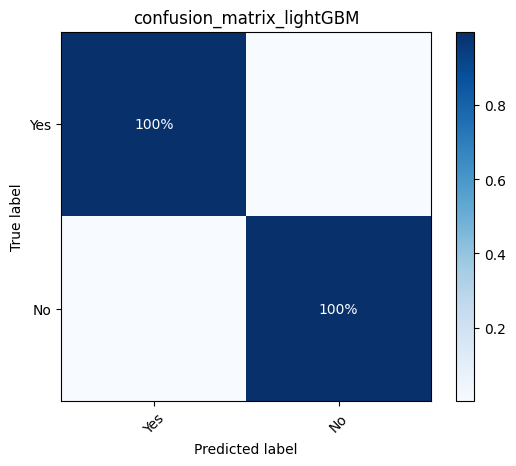

In [21]:
best_params = study.best_params
print(f"Best Params: {best_params}")
optuna.visualization.plot_param_importances(study).show()
optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_slice(study).show()

In [20]:
# XGBoost Parameters
def objective(trial):
    Params = {
        'n_estimators': ttrial.suggest_int('n_estimators',10,1000),
        'num_leaves': trial.suggest_int('num_leaves', 100, 1000),
#         'learning_rate': trial.suggest_categorical('learning_rate',[0.005 * i for i in range(1,21)]),
#         'max_depth':trial.suggest_int('max_depth',10,50),
#         'min_child_weight': trial.suggest_categorical('min_child_weight',[0.01,0.001,0.0001,0.00001,0.000001,0]),
#         'min_child_samples': trial.suggest_int('min_child_samples',10, 50),
#         'subsample': trial.suggest_categorical('subsample',[0.8,0.9,1]),
#         'colsample_bytree': trial.suggest_categorical('colsample_bytree',[0.8,0.9,1]),
        'objective': 'binary:logistic',
        'eval_metric': 'auc'
             }
    
    xgb_mcc = []
    for i in range(k):
        X_kos = X_kos_folds[i]
        y_kos = y_kos_folds[i]
        df_test = df_test_folds[i]
        feat_cols = feat_cols_folds[i]

        # train the model
        xgb_model = xgb.XGBClassifier(**Params)
        xgb_model.fit(X_kos,y_kos)
        test_predictions = xgb_model.predict_proba(df_test[feat_cols])[:, 1]
        test_labels = [i >= 0.5 for i in test_predictions]
        mcc = MCC(df_test['y'], test_labels)
        xgb_mcc.append(mcc)

    return sum(xgb_mcc)/5

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50,show_progress_bar=True)

Cross-validation scores: [0.99303751 0.99204872 0.99225771 0.99206444 0.99166991]
Mean AUC: 0.9922156587319659


In [21]:
best_params = study.best_params
print(f"Best Params: {best_params}")
optuna.visualization.plot_param_importances(study).show()
optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_slice(study).show()

array([[3994,    6],
       [   1,  520]], dtype=int64)

In [27]:
# Random Forest
def objective(trial):
    Params = {
        'n_estimators': trial.suggest_int('n_estimators',10,1000),
        'max_features': trial.suggest_int('num_leaves', 5, 32),
             }

    rf_mcc = []
    for i in range(k):
        X_kos = X_kos_folds[i]
        y_kos = y_kos_folds[i]
        df_test = df_test_folds[i]
        feat_cols = feat_cols_folds[i]

        # train the model
        rf = RandomForestClassifier(**Params)
        rf_model.fit(X_kos,y_kos)
        test_predictions = rf_model.predict_proba(df_test[feat_cols])[:, 1]
        test_labels = [i >= 0.5 for i in test_predictions]
        mcc = MCC(df_test['y'], test_labels)
        rf_mcc.append(mcc)

    return sum(rf_mcc)/5

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50,show_progress_bar=True)    
    
rf = RandomForestClassifier(**rf_params)
rf_cv_scores = cross_val_score(rf, X_kos, y_kos, cv=cv, scoring='roc_auc')

print("Cross-validation scores:", rf_cv_scores)
print("Mean AUC:", rf_cv_scores.mean())

Cross-validation scores: [0.98766194 0.98887224 0.98755529 0.9879586  0.98878489]
Mean AUC: 0.9881665932530626


In [28]:
best_params = study.best_params
print(f"Best Params: {best_params}")
optuna.visualization.plot_param_importances(study).show()
optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_slice(study).show()

[[3989   11]
 [   1  520]]


0.987148548242192